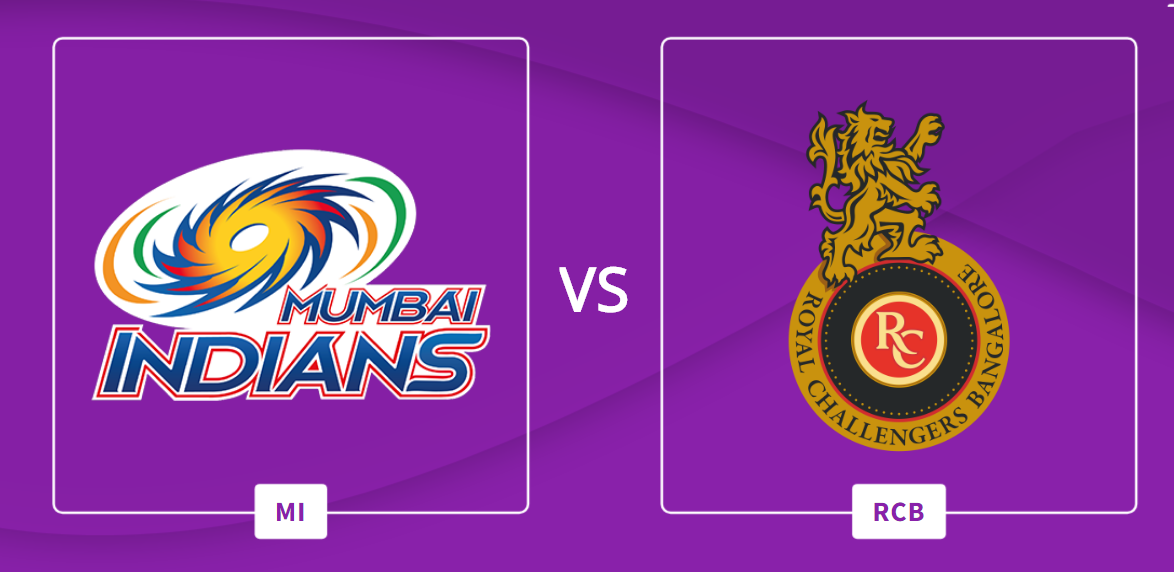

In [1]:
#!pip install bqplot
#!pip install ipywidgets
#!pip install ipympl
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter nbextension install --user --py widgetsnbextension
#!jupyter nbextension enable --user --py widgetsnbextension
#!pip install plotly
#!pip install cufflinks


import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
import bqplot
from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip
import cufflinks as cf
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
pd.set_option('display.max_columns', 50)
%matplotlib widget


In [4]:
matches = pd.read_csv("matches.csv")
deliveries =  pd.read_csv("deliveries.csv")
IPL_data = pd.merge(deliveries, matches[['id','season', 'team1', 'team2', 'toss_winner', 'toss_decision','winner','result', 'dl_applied','win_by_runs','win_by_wickets', 'venue' ]], 
                    left_on='match_id', right_on='id')

In [22]:
#MI batsmen
MI_batsmen = ['SS Tiwary', 'Q de Kock', 'SA Yadav', 'Ishan Kishan', 'HH Pandya', 'KH Pandya', 'KA Pollard']
#'RG Sharma', : injured will not play

#MI bowlers
MI_bowlers = ['JJ Bumrah', 'TA Boult', 'RD Chahar', 'KH Pandya', 'KA Pollard']
#J Pattinson data not available


RCB_batsmen = ['AJ Finch', 'V Kohli', 'AB de Villiers', 'Washington Sundar','Gurkeerat Singh', 'S Dube', 'CH Morris']
#D Paddikal: new player, S Dube/ Gurkeerat (optional)

RCB_bowlers = ['CH Morris', 'YS Chahal', 'N Saini', 'Washington Sundar','Mohammed Siraj']
# I Udana new player: Bowler ER:9.72

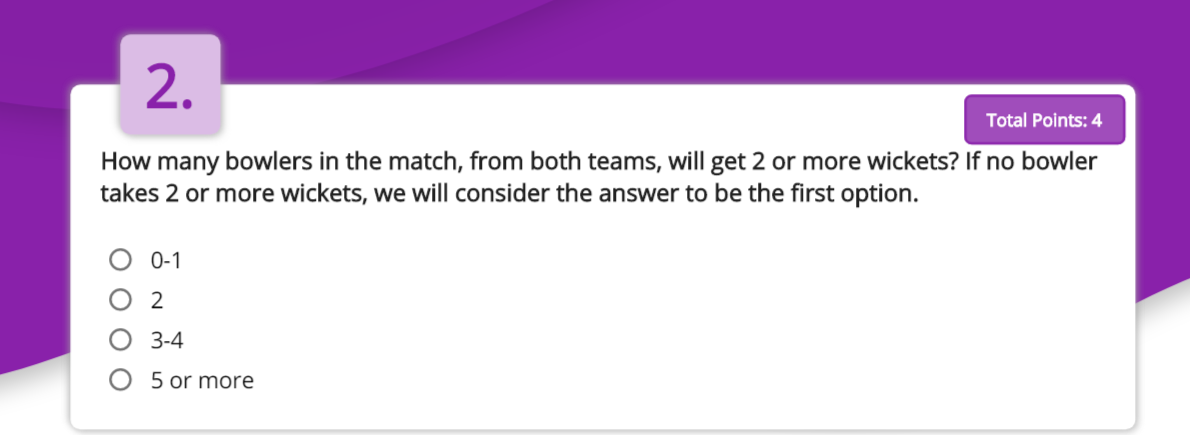

In [24]:
def wickets_data(data):
    for i in data.bowler.unique():
        b.append(i)
        x =  data[data.bowler == i]
        w.append(x.wickets.mean())
        n_m.append(x.shape[0])
        m_w.append(x[x.wickets >=2].shape[0])
        n_w.append(x[x.wickets ==0].shape[0])
        w_w.append(x[x.wickets !=0].shape[0])
        l_w.append(x[x.wickets <2].shape[0])
    wickets_MI_RCB = pd.DataFrame(list(zip(b, n_m, w_w, w, m_w, n_w, l_w)), 
               columns =['bowler','no_of_matches', 'no_of_wickets','avg_wickets', ">=2_wickets", "no_wickets", "<2_wickets"])    
    wickets_MI_RCB[">=2_wickets_%"] = (wickets_MI_RCB['>=2_wickets']/wickets_MI_RCB.no_of_wickets)*100
    wickets_MI_RCB["<2_wickets_%"] = (wickets_MI_RCB['<2_wickets']/wickets_MI_RCB.no_of_wickets)*100
    
    return wickets_MI_RCB

## 2.1 : Overall IPL performance

In [29]:
wickets = deliveries[(deliveries.bowler.isin(MI_bowlers)) | (deliveries.bowler.isin(RCB_bowlers))]
wickets.player_dismissed.fillna(0, inplace = True)
wickets['player_dismissed'].loc[wickets['player_dismissed'] != 0] = 1
w1 = wickets.groupby(['match_id', 'bowler'])['player_dismissed'].sum().reset_index(name = "wickets")

b =[]; w = []; m_w = []; n_m=[];n_w = [];l_w=[];w_w=[]
wickets_MI_RCB1 = wickets_data(w1)

x1 = wickets_MI_RCB1[wickets_MI_RCB1.bowler.isin(MI_bowlers)]
x2 = wickets_MI_RCB1[wickets_MI_RCB1.bowler.isin(RCB_bowlers)]
display_side_by_side([x1, x2],["1) MI Bowlers", "2) RCB Bowlers"])

,bowler,no_of_matches,no_of_wickets,avg_wickets,>=2_wickets,no_wickets,<2_wickets,>=2_wickets_%,<2_wickets_%
1,JJ Bumrah,77,52,1.181818,25,25,52,48.076923,100.000000
2,KA Pollard,81,45,0.827160,17,36,64,37.777778,142.222222
3,KH Pandya,53,24,0.792453,13,29,40,54.166667,166.666667
4,TA Boult,33,26,1.242424,12,7,21,46.153846,80.769231
5,RD Chahar,15,9,1.000000,4,6,11,44.444444,122.222222
,bowler,no_of_matches,no_of_wickets,avg_wickets,>=2_wickets,no_wickets,<2_wickets,>=2_wickets_%,<2_wickets_%
0,YS Chahal,83,62,1.228916,30,21,53,48.387097,85.483871
6,CH Morris,61,43,1.278689,24,18,37,55.813953,86.046512
7,Mohammed Siraj,26,18,1.153846,8,8,18,44.444444,100.000000
8,Washington Sundar,20,11,0.850000,4,9,16,36.363636,145.454545


## only consider consider ">=2_wickets_% " > 50
## Conclusion , 2- 3 Bowlers will take 2 or more wickets todays

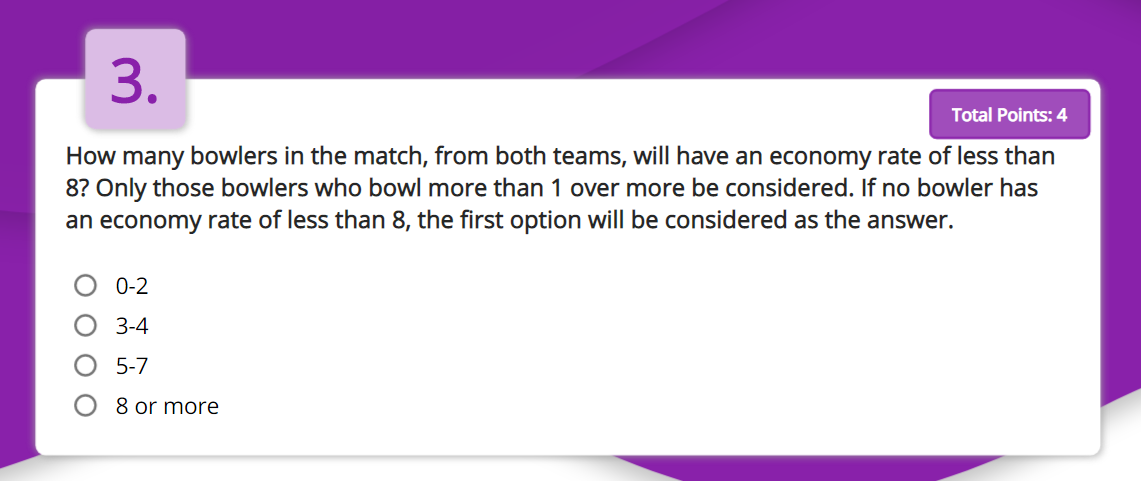

## 3.1 Overall

In [44]:
MI_RCB_ER = deliveries[(deliveries.bowler.isin(MI_bowlers)) | (deliveries.bowler.isin(RCB_bowlers))]
er1 = MI_RCB_ER.groupby(['bowler'])['batsman_runs'].count().reset_index(name = "balls_bowled")
er2 = MI_RCB_ER.groupby(['bowler'])['batsman_runs'].sum().reset_index(name = "total_runs")
er1["total_runs"] = er2.total_runs
er1["economy_rate"] = (er1.total_runs/er1.balls_bowled)*6
er1

e1 = MI_RCB_ER.groupby(['match_id', 'bowler'])['batsman_runs'].count().reset_index(name = "balls_bowled")
e2 = MI_RCB_ER.groupby(['match_id','bowler'])['batsman_runs'].sum().reset_index(name = "total_runs")
e1["total_runs"] = e2.total_runs
e1["economy_rate"] = (e1.total_runs/e1.balls_bowled)*6


def economy_calculator(data):
    for i in data.bowler.unique():
        bowler.append(i)                                    
        balls.append(round(data[data.bowler == i].balls_bowled.mean(),1))
        tr.append(round(data[data.bowler == i].total_runs.mean(),1))
    ER_MI_RCB = pd.DataFrame(list(zip(bowler, balls, tr)), 
               columns =['bowler','balls_bowled', 'total_runs'])  
    ER_MI_RCB["economy_rate"] = round((ER_MI_RCB.total_runs/ER_MI_RCB.balls_bowled)*6, 1)    
    return ER_MI_RCB
    
balls = []; bowler =[];tr = []
ER_MI_RCB_ = economy_calculator(e1)

display_side_by_side([er1[er1.bowler.isin(MI_bowlers)], er1[er1.bowler.isin(RCB_bowlers)],
                     ER_MI_RCB_[ER_MI_RCB_.bowler.isin(MI_bowlers)],ER_MI_RCB_[ER_MI_RCB_.bowler.isin(RCB_bowlers)] ],
                     ["1) MI Bowlers overall economy in IPL", "2) RCB Bowlers overall economy in IPL", 
                      "3) MI bowlers average economy", "4) RCB bowlers average economy"]) 


,bowler,balls_bowled,total_runs,economy_rate
1,JJ Bumrah,1798,2180,7.274750
2,KA Pollard,1276,1688,7.937304
3,KH Pandya,968,1117,6.923554
6,RD Chahar,333,364,6.558559
7,TA Boult,802,1109,8.296758
,bowler,balls_bowled,total_runs,economy_rate
0,CH Morris,1335,1692,7.604494
4,Mohammed Siraj,584,852,8.753425
5,N Saini,300,410,8.200000
8,Washington Sundar,358,452,7.575419


## 3.2 Head to Head

In [52]:
MI_RCB_ER_ = deliveries[((deliveries.bowler.isin(MI_bowlers)) & (deliveries.batsman.isin(RCB_batsmen))) | 
                       ((deliveries.bowler.isin(RCB_bowlers)) & (deliveries.batsman.isin(MI_batsmen)))]

er1_ = MI_RCB_ER_.groupby(['bowler'])['batsman_runs'].count().reset_index(name = "balls_bowled")
er2_ = MI_RCB_ER_.groupby(['bowler'])['batsman_runs'].sum().reset_index(name = "total_runs")
er1_["total_runs"] = er2_.total_runs
er1_["economy_rate"] = (er1_.total_runs/er1_.balls_bowled)*6

e1_= MI_RCB_ER_.groupby(['match_id', 'bowler'])['batsman_runs'].count().reset_index(name = "balls_bowled")
e2_ = MI_RCB_ER_.groupby(['match_id','bowler'])['batsman_runs'].sum().reset_index(name = "total_runs")
e1_["total_runs"] = e2_.total_runs
e1_["economy_rate"] = (e1_.total_runs/e1_.balls_bowled)*6

balls = []; bowler =[];tr = []
ER_MI_RCB_1 = economy_calculator(e1_)

display_side_by_side([er1_[er1_.bowler.isin(MI_bowlers)], er1_[er1_.bowler.isin(RCB_bowlers)],
                     ER_MI_RCB_1],
                     ["1) MI Bowlers overall economy in IPL against RCB batsmen", "2) RCB Bowlers overall economy in IPL against MI batsmen", 
                      "3) MI and RCB head to head"]) 


,bowler,balls_bowled,total_runs,economy_rate
1,JJ Bumrah,180,227,7.566667
2,KA Pollard,47,51,6.510638
3,KH Pandya,119,129,6.504202
6,RD Chahar,18,19,6.333333
7,TA Boult,46,74,9.652174
,bowler,balls_bowled,total_runs,economy_rate
0,CH Morris,58,79,8.172414
4,Mohammed Siraj,64,82,7.687500
5,N Saini,23,39,10.173913
8,Washington Sundar,33,35,6.363636


## Conclusion: Around 6-7 bowlers will have economies less than 8

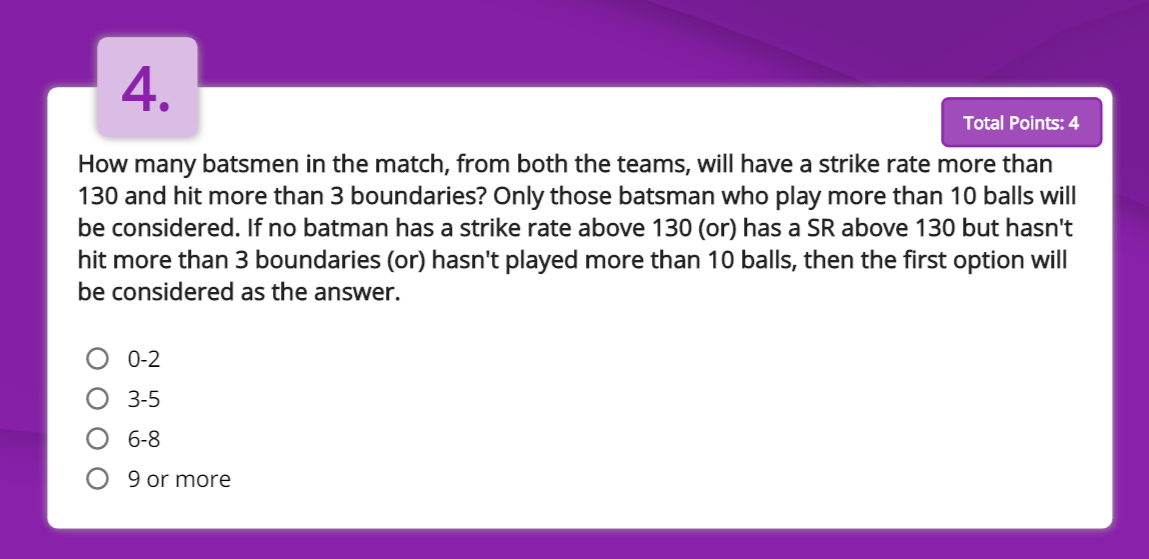

## 4.1

In [69]:
from statistics import mean
batsmen = deliveries[(deliveries.batsman.isin(MI_batsmen)) | (deliveries.batsman.isin(RCB_batsmen))]

sr1 = batsmen.groupby(['match_id', 'batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
sr2 = batsmen.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index(name = "runs_scored")
sr1["runs_scored"] = sr2.runs_scored


def strikerates(data):
    for i in data.batsman.unique():
        bt1 = data[data.batsman ==i]
        bats.append(i)
        bf1.append(bt1.balls_faced.mean())
        rs.append(bt1.runs_scored.mean())
        d = batsmen[(batsmen.batsman_runs == 6) | (batsmen.batsman_runs == 4)][batsmen.batsman == i]
        bo = []
        for j in d.match_id.unique():
            bo.append(d[d.match_id == j].batsman_runs.count())
        
        boundaries.append(mean(bo))
    Strike_Rate = pd.DataFrame(list(zip(bats, bf1, rs, boundaries)), 
               columns =['batsman','balls_faced', 'total_runs', "no_of_boundaries"])
    Strike_Rate["strike_rate"] = Strike_Rate.total_runs*100/Strike_Rate.balls_faced
    return Strike_Rate
 
bats=[];bf1 =[];rs =[]; boundaries=[]
Strike_Rate_ = strikerates(sr1)
display_side_by_side([ Strike_Rate_[Strike_Rate_.batsman.isin(MI_batsmen)], 
                      Strike_Rate_[Strike_Rate_.batsman.isin(RCB_batsmen)]],
                     ["1) Strike rate of MI batsmen", "2) Strike rate of RCB batsmen"]) 


,batsman,balls_faced,total_runs,no_of_boundaries,strike_rate
0,HH Pandya,12.065574,18.327869,3,151.902174
1,KA Pollard,14.878788,21.090909,3,141.751527
2,KH Pandya,13.804348,19.891304,3,144.094488
5,SA Yadav,11.404762,14.476190,2,126.931106
8,Ishan Kishan,16.545455,21.545455,4,130.219780
10,SS Tiwary,17.359375,19.937500,2,114.851485
12,Q de Kock,22.720000,29.780000,5,131.073944
,batsman,balls_faced,total_runs,no_of_boundaries,strike_rate
3,AJ Finch,18.794521,23.890411,4,127.113703
4,CH Morris,9.162162,14.054054,3,153.392330


## 4.2 Head to Head

In [71]:
from statistics import mean
batsmen1 = deliveries[((deliveries.bowler.isin(MI_bowlers)) & (deliveries.batsman.isin(RCB_batsmen))) | 
                       ((deliveries.bowler.isin(RCB_bowlers)) & (deliveries.batsman.isin(MI_batsmen)))]
sr1_ = batsmen1.groupby(['match_id', 'batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
sr2_ = batsmen1.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index(name = "runs_scored")
sr1_["runs_scored"] = sr2_.runs_scored

bats=[];bf1 =[];rs =[]; boundaries=[]
Strike_Rate_1 = strikerates(sr1_)
display_side_by_side([ Strike_Rate_1[Strike_Rate_1.batsman.isin(MI_batsmen)], 
                      Strike_Rate_1[Strike_Rate_1.batsman.isin(RCB_batsmen)]],
                     ["1) Strike rate of MI batsmen against RCB bowlers", "2) Strike rate of RCB batsmen against MI bowlers"]) 


,batsman,balls_faced,total_runs,no_of_boundaries,strike_rate
1,HH Pandya,7.900000,12.500000,3,158.227848
2,KA Pollard,4.222222,4.555556,3,107.894737
3,KH Pandya,6.000000,6.666667,3,111.111111
6,SA Yadav,3.375000,3.375000,2,100.000000
9,Ishan Kishan,6.666667,11.333333,4,170.000000
10,Q de Kock,7.500000,10.666667,5,142.222222
11,SS Tiwary,6.000000,5.500000,2,91.666667
,batsman,balls_faced,total_runs,no_of_boundaries,strike_rate
0,AB de Villiers,8.647059,10.352941,5,119.727891
4,V Kohli,9.444444,12.833333,4,135.882353


## Conclusion: From analysis done in Part 4.1 and 4.2 there will be 3-5 batsmen having strike rate greater than 130 and more than 3 boundaries at the same time

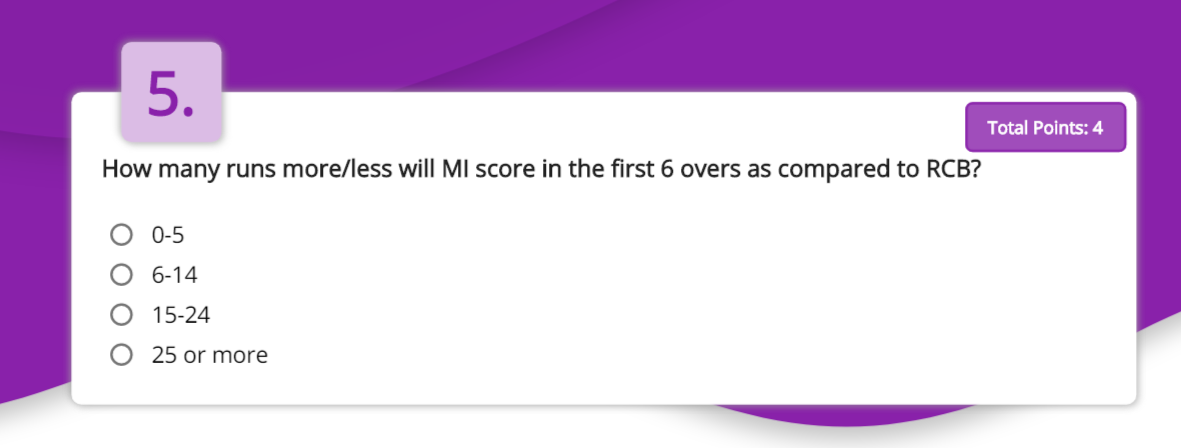

In [83]:
#from section 4.1
MI_batsmen_pp = ['Ishan Kishan', 'Q de Kock', 'SA Yadav']
RCB_batsmen_pp =['AJ Finch','V Kohli','AB de Villiers']

runs_1 = Strike_Rate_1[Strike_Rate_1.batsman.isin(MI_batsmen_pp)]
runs_2 = Strike_Rate_1[Strike_Rate_1.batsman.isin(RCB_batsmen_pp)]
display_side_by_side([ runs_1[["batsman", "balls_faced", "total_runs"]], runs_2[["batsman", "balls_faced", "total_runs"]], runs_1[["batsman", "balls_faced", "total_runs"]].cumsum(), runs_2[["batsman", "balls_faced", "total_runs"]].cumsum()],
                     ["1) Strike rate of MI batsmen ", "2) Strike rate of RCB batsmen ",
                     "1) Strike rate of MI batsmen (cumulative)", "2) Strike rate of RCB batsmen s(cumulative)"]) 
                       

,batsman,balls_faced,total_runs
6,SA Yadav,3.375000,3.375000
9,Ishan Kishan,6.666667,11.333333
10,Q de Kock,7.500000,10.666667
,batsman,balls_faced,total_runs
0,AB de Villiers,8.647059,10.352941
4,V Kohli,9.444444,12.833333
5,AJ Finch,9.714286,9.571429
,batsman,balls_faced,total_runs
6,SA Yadav,3.375000,3.375000
9,SA YadavIshan Kishan,10.041667,14.708333


## Diffrence in runs will be 6-14

# Question 1: Who will win the match?

In [84]:
bowling_avg = deliveries[(deliveries.bowler.isin(MI_bowlers)) | (deliveries.bowler.isin(RCB_bowlers))]
bowling_avg.player_dismissed.fillna(0, inplace  = True)
bowling_avg['player_dismissed'].loc[bowling_avg['player_dismissed'] != 0] = 1

b_avg1 = bowling_avg.groupby(['bowler'])['player_dismissed'].sum().reset_index(name  = "wickets")
t_b =  bowling_avg.groupby(['bowler'])['batsman_runs'].count().reset_index(name  = "balls_bowled")
b_avg1["balls_bowled"] = t_b.balls_bowled
b_avg1["bowling_avg"] = b_avg1.wickets/b_avg1.balls_bowled


display_side_by_side([b_avg1[b_avg1.bowler.isin(MI_bowlers)], b_avg1[b_avg1.bowler.isin(RCB_bowlers)]], 
                     [" 1) bowling average of MI bowlers", " 2) bowling average of RCB bowlers"])


## Batting averages of all the batsmen

batsmen_runs_all =deliveries[(deliveries.batsman.isin(MI_batsmen)) | (deliveries.batsman.isin(RCB_batsmen))]
b1_all = batsmen_runs_all.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_runs")
b = [];b_avg = [];tm = [];runs  = []
for i in batsmen_runs_all.batsman.unique():
    x = batsmen_runs_all[batsmen_runs_all.batsman == i]
    x.player_dismissed.fillna(0, inplace = True)
    x['player_dismissed'].loc[x['player_dismissed'] != 0] = 1
    #print(x[['match_id','player_dismissed']])
    y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
    z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
    #print(y)
    b.append(i)
    b_avg.append(y.out_count.sum())
    runs.append(z.runs.sum())
    tm.append(y.shape[0])
    
bat_avg = pd.DataFrame(list(zip(b, b_avg, tm, runs)), 
               columns =['batsman','matches_out','total_matches', 'total_runs'])    

bat_avg["batting_average"] = bat_avg.total_runs/bat_avg.matches_out
#bat_avg[bat_avg.batsman.isin(SRH_batsmen)]
display_side_by_side([bat_avg[bat_avg.batsman.isin(MI_batsmen)], bat_avg[bat_avg.batsman.isin(RCB_batsmen)]], [" 1) batting average of MI batsmen", " 2) batting average of RCB batsmen"])

,bowler,wickets,balls_bowled,bowling_avg
1,JJ Bumrah,91,1798,0.050612
2,KA Pollard,67,1276,0.052508
3,KH Pandya,42,968,0.043388
6,RD Chahar,15,333,0.045045
7,TA Boult,41,802,0.051122
,bowler,wickets,balls_bowled,bowling_avg
0,CH Morris,78,1335,0.058427
4,Mohammed Siraj,30,584,0.051370
5,N Saini,12,300,0.040000
8,Washington Sundar,17,358,0.047486


,batsman,matches_out,total_matches,total_runs,batting_average
0,KH Pandya,32,46,915,28.593750
1,KA Pollard,102,132,2784,27.294118
2,HH Pandya,39,61,1118,28.666667
5,SA Yadav,29,42,608,20.965517
8,Ishan Kishan,31,33,711,22.935484
10,SS Tiwary,43,64,1276,29.674419
12,Q de Kock,46,50,1489,32.369565
,batsman,matches_out,total_matches,total_runs,batting_average
3,AJ Finch,66,73,1744,26.424242
4,CH Morris,20,37,520,26.000000


In [89]:
print("overall batting average of MI is :",bat_avg[bat_avg.batsman.isin(MI_batsmen)].batting_average.mean())
print("overall batting average of RCB is :", bat_avg[bat_avg.batsman.isin(RCB_batsmen)].batting_average.mean())

overall batting average of MI is : 27.214217035445
overall batting average of RCB is : 24.43881118881119


In [90]:
print("overall bowling average of MI is :",b_avg1[b_avg1.bowler.isin(MI_bowlers)].bowling_avg.mean())
print("overall bowling average of RCB is :", b_avg1[b_avg1.bowler.isin(RCB_bowlers)].bowling_avg.mean())

overall bowling average of MI is : 0.048535059436035324
overall bowling average of RCB is : 0.050537506839927936


## Performance indexes of batsmen
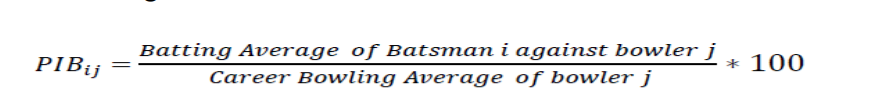

In [91]:
# Performance indexes of MI batsmen against RCB bowlers
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
def performance_indexes_batsmen(batsman_list, bowler_list):
    
    for i in batsman_list:
        pi1 = deliveries[(deliveries.batsman == i) & (deliveries.bowler.isin(bowler_list))]
        pi1.player_dismissed.fillna(0, inplace = True)
        pi1['player_dismissed'].loc[pi1['player_dismissed'] != 0] = 1
        for j in pi1.bowler.unique():
            x = pi1[pi1.bowler == j]
            batsman.append(i)
            bowler.append(j)
            y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
            z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
            b_avg.append(y.out_count.sum())
            runs.append(z.runs.sum())
            tm.append(y.shape[0])
            
performance_indexes_batsmen(MI_batsmen, RCB_bowlers)
MI_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
MI_bat_avg["batting_average"] = MI_bat_avg.total_runs/MI_bat_avg.matches_out
MI_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg = []
for i in MI_bat_avg.bowler.values:
    bowl_avg.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
MI_bat_avg["bowling_average_bowler"] = bowl_avg
MI_bat_avg["PIBij"] = MI_bat_avg.batting_average/MI_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %

#############################################################################################################33
# RCB batsmen's performance indexes
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
performance_indexes_batsmen(RCB_batsmen, MI_bowlers)

RCB_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
RCB_bat_avg["batting_average"] = RCB_bat_avg.total_runs/RCB_bat_avg.matches_out
RCB_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg1 = []
for i in RCB_bat_avg.bowler.values:
    bowl_avg1.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
RCB_bat_avg["bowling_average_bowler"] = bowl_avg1
RCB_bat_avg["PIBij"] = RCB_bat_avg.batting_average/RCB_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %
display_side_by_side([MI_bat_avg, RCB_bat_avg], [" 1) Performance indexes of SRH batsmen against DC Bowlers", " 2) Performance indexes of DC batsmen against SRH Bowlers"])

,batsman,bowler,matches_out,total_matches,total_runs,batting_average,bowling_average_bowler,PIBij
0,SS Tiwary,YS Chahal,1,2,11,11.000000,0.055405,198.539216
1,Q de Kock,YS Chahal,3,5,30,10.000000,0.055405,180.490196
2,Q de Kock,N Saini,0,2,15,nan,0.040000,nan
3,Q de Kock,Mohammed Siraj,0,2,8,nan,0.051370,nan
4,Q de Kock,CH Morris,0,1,11,nan,0.058427,nan
5,SA Yadav,CH Morris,1,3,8,8.000000,0.058427,136.923077
6,SA Yadav,YS Chahal,0,5,19,nan,0.055405,nan
7,Ishan Kishan,Washington Sundar,0,1,11,nan,0.047486,nan
8,Ishan Kishan,Mohammed Siraj,1,1,17,17.000000,0.051370,330.933333
9,Ishan Kishan,YS Chahal,1,1,6,6.000000,0.055405,108.294118


## Performance indexes for both the teams bowlers
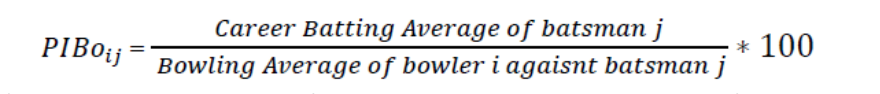

In [93]:
bowls = []; bats = []; wi = []; bb = []
def performance_index_bowlers(bowlers_list, batsmen_list):
    for i in bowlers_list:
        p = deliveries[(deliveries.bowler == i) & (deliveries.batsman.isin(batsmen_list))]
        p.player_dismissed.fillna(0, inplace  = True)
        p['player_dismissed'].loc[p['player_dismissed'] != 0] = 1
        for j in p.batsman.unique():
            bowls.append(i)
            bats.append(j)
            xy = p[p.batsman == j]
            #print(p[p.batsman == j])
            wi.append(xy.player_dismissed.sum())
            bb.append(xy.batsman_runs.count())
        
performance_index_bowlers(MI_bowlers, RCB_batsmen)
MI_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in MI_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
MI_bowlers_p["bowling_average"] = MI_bowlers_p.wickets/MI_bowlers_p.balls_bowled
MI_bowlers_p["batting_avg"] = bat_avg_p
MI_bowlers_p["PIBoij"] = MI_bowlers_p.batting_avg/MI_bowlers_p.bowling_average
MI_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)
###################################################################################################################
bowls = []; bats = []; wi = []; bb = []        
performance_index_bowlers(RCB_bowlers, MI_batsmen)

RCB_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in RCB_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
RCB_bowlers_p["bowling_average"] = RCB_bowlers_p.wickets/RCB_bowlers_p.balls_bowled
RCB_bowlers_p["batting_avg"] = bat_avg_p
RCB_bowlers_p["PIBoij"] = RCB_bowlers_p.batting_avg/RCB_bowlers_p.bowling_average
RCB_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)

display_side_by_side([MI_bowlers_p, RCB_bowlers_p], [" 1) Performance indexes of MI bowlers against RCB batsmen", " 2) Performance indexes of RCB bowlers against MI batsmen"])

,bowler,batsman,wickets,balls_bowled,bowling_average,batting_avg,PIBoij
0,JJ Bumrah,V Kohli,2,73,0.027397,35.750000,1304.875000
1,JJ Bumrah,AB de Villiers,2,60,0.033333,42.576923,1277.307692
2,JJ Bumrah,CH Morris,0,14,0.000000,26.000000,nan
3,JJ Bumrah,Washington Sundar,0,2,0.000000,13.166667,nan
4,JJ Bumrah,AJ Finch,1,30,0.033333,26.424242,792.727273
5,JJ Bumrah,S Dube,0,1,0.000000,10.000000,nan
6,TA Boult,V Kohli,0,26,0.000000,35.750000,nan
7,TA Boult,AB de Villiers,1,13,0.076923,42.576923,553.500000
8,TA Boult,AJ Finch,0,7,0.000000,26.424242,nan
9,RD Chahar,AJ Finch,0,5,0.000000,26.424242,nan


## Conclusion : MI will win today